# Business Insights: User Segmentation and ROI Analysis

This notebook translates uplift predictions into actionable business recommendations:

1. **Segment users** into four categories:
   - **Persuadables**: High uplift, low baseline (target these!)
   - **Sure-things**: Low uplift, high baseline (would buy anyway)
   - **Lost causes**: Low uplift, low baseline (not worth targeting)
   - **Do-not-disturb**: Negative uplift (campaign hurts them)

2. **Quantify business impact**:
   - Incremental revenue from targeting persuadables
   - Cost savings vs. blanket targeting
   - Optimal targeting strategy

3. **Executive recommendations**


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
PROJECT_ROOT = "/Users/mbgirish/Causal Impact & Uplift Modeling"
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

from preprocessing import ColumnConfig
from uplift_models import segment_uplift_quadrants

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

# Load uplift predictions from previous notebook
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
uplift_file = os.path.join(RESULTS_PATH, "uplift_predictions.csv")

if os.path.exists(uplift_file):
    df_uplift = pd.read_csv(uplift_file)
    print(f"✓ Loaded uplift predictions from {uplift_file}")
else:
    print("⚠ Uplift predictions not found. Run notebook 03_uplift_modeling.ipynb first.")
    # Create dummy data for demonstration
    np.random.seed(42)
    n = 3000
    df_uplift = pd.DataFrame({
        "user_id": [f"user_{i}" for i in range(n)],
        "uplift": np.random.normal(0.1, 0.15, n),
        "p_treated": np.random.beta(2, 5, n),
        "p_control": np.random.beta(2, 5, n),
    })
    df_uplift["uplift"] = df_uplift["p_treated"] - df_uplift["p_control"]
    print("⚠ Using synthetic data for demonstration")

print(f"\nData shape: {df_uplift.shape}")
print(df_uplift.head())


✓ Loaded uplift predictions from /Users/mbgirish/Causal Impact & Uplift Modeling/results/uplift_predictions.csv

Data shape: (19200, 4)
      user_id    uplift  p_treated  p_control
0  user_52893  0.014708   0.089153   0.074446
1   user_8261  0.078699   0.180036   0.101338
2  user_59080  0.076062   0.193474   0.117412
3  user_28326  0.072687   0.135098   0.062412
4  user_12695  0.038093   0.206923   0.168829


## 1. User Segmentation into Four Quadrants


User Segmentation Summary:
               uplift                 p_control p_treated
                count    mean     std      mean      mean
uplift_segment                                           
do_not_disturb   1184 -0.0319  0.0339    0.1825    0.1505
lost_cause         45  0.0520  0.0419    0.3293    0.3813
persuadable     17716  0.0702  0.0466    0.0957    0.1659
sure_thing        255 -0.1927  0.1302    0.4200    0.2273


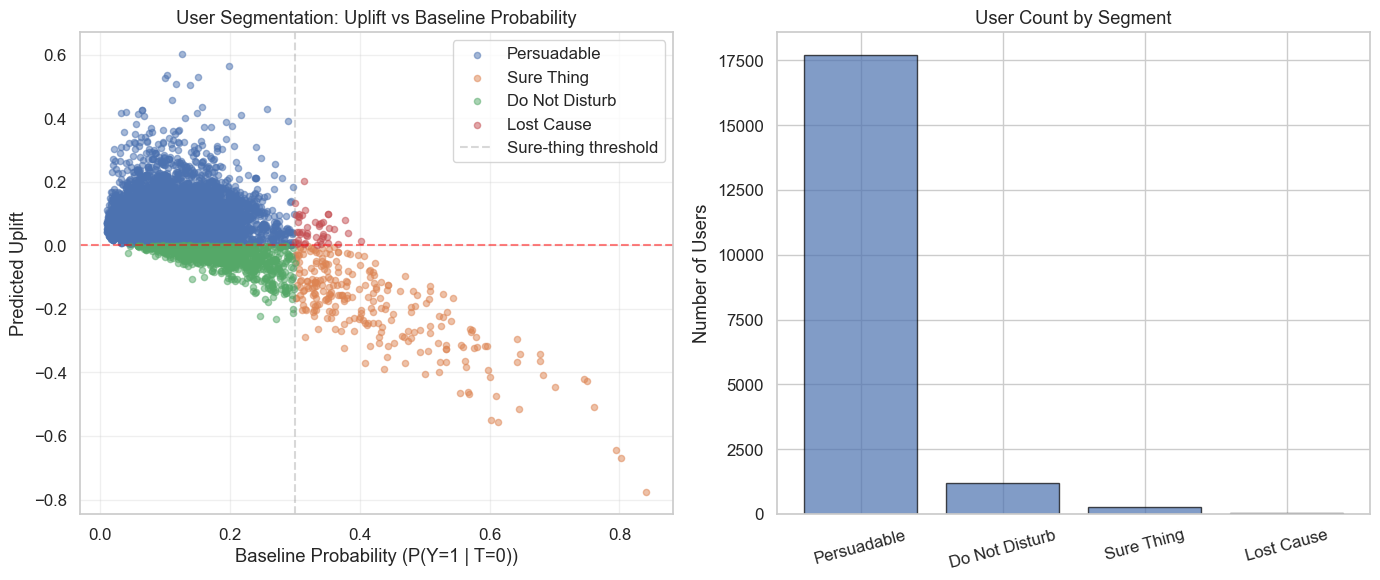

In [2]:
# Create a dummy TwoModelResult for segmentation function
from dataclasses import dataclass
from uplift_models import TwoModelResult

# Segment users
df_segmented = segment_uplift_quadrants(
    df_uplift,
    TwoModelResult(
        model_treated=None,  # Not needed for segmentation
        model_control=None,
        uplift_col="uplift",
        p_treated_col="p_treated",
        p_control_col="p_control",
    ),
    base_prob_col="p_control",
    persuadable_threshold=0.0,
    sure_thing_threshold=0.3,
)

# Summary statistics
segment_summary = df_segmented.groupby("uplift_segment").agg({
    "uplift": ["count", "mean", "std"],
    "p_control": "mean",
    "p_treated": "mean",
}).round(4)

print("User Segmentation Summary:")
print(segment_summary)

# Visualize segmentation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: uplift vs baseline probability
for segment in df_segmented["uplift_segment"].unique():
    mask = df_segmented["uplift_segment"] == segment
    axes[0].scatter(
        df_segmented.loc[mask, "p_control"],
        df_segmented.loc[mask, "uplift"],
        label=segment.replace("_", " ").title(),
        alpha=0.5,
        s=20,
    )

axes[0].axhline(0, color="red", linestyle="--", alpha=0.5)
axes[0].axvline(0.3, color="gray", linestyle="--", alpha=0.3, label="Sure-thing threshold")
axes[0].set_xlabel("Baseline Probability (P(Y=1 | T=0))")
axes[0].set_ylabel("Predicted Uplift")
axes[0].set_title("User Segmentation: Uplift vs Baseline Probability")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bar chart: segment sizes
segment_counts = df_segmented["uplift_segment"].value_counts()
axes[1].bar(
    [s.replace("_", " ").title() for s in segment_counts.index],
    segment_counts.values,
    alpha=0.7,
    edgecolor="black",
)
axes[1].set_ylabel("Number of Users")
axes[1].set_title("User Count by Segment")
axes[1].tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()


## 2. Business Impact Analysis

Compare different targeting strategies:
1. **Random targeting** (baseline)
2. **Target all users** (current practice)
3. **Uplift-based targeting** (target top-k% by predicted uplift)
4. **Smart targeting** (target only persuadables)


Targeting Strategy Comparison:
                 Strategy  N_targeted  Target_fraction   Cost  Expected_incremental_conversions  Expected_incremental_revenue       ROI
             Random (30%)        5743         0.299115 2871.5                        349.604582                  17480.229106  5.087491
               Target All       19200         1.000000 9600.0                       1159.715014                  57985.750715  5.040182
   Uplift-based (top 30%)        5760         0.300000 2880.0                        691.425493                  34571.274649 11.003915
Smart (Persuadables only)       17716         0.922708 8858.0                       1244.338663                  62216.933131  6.023813


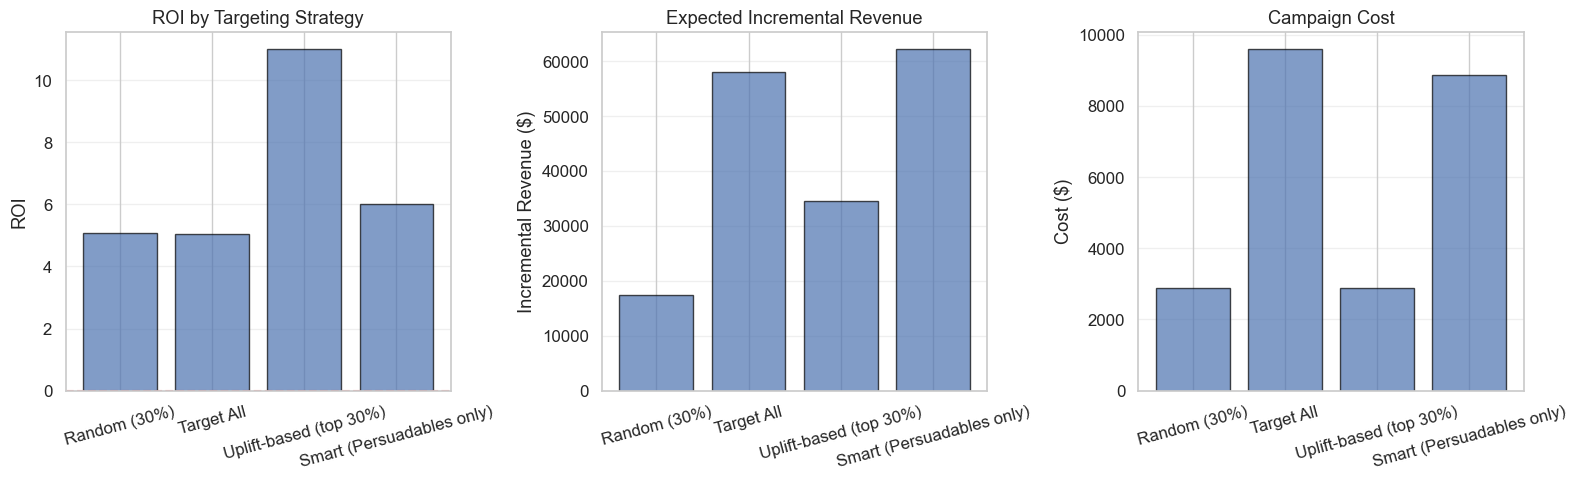

In [3]:
# Business assumptions (adjust based on your business)
COST_PER_CAMPAIGN = 0.50  # Cost to send campaign to one user
REVENUE_PER_CONVERSION = 50.0  # Average revenue per purchase
TARGET_FRACTION = 0.3  # Target top 30% of users

# For demonstration, we'll simulate outcomes
# In practice, you'd use actual test set outcomes
np.random.seed(42)
df_segmented["actual_outcome"] = np.random.binomial(
    1,
    df_segmented["p_treated"] * 0.8 + df_segmented["p_control"] * 0.2,  # Simulated
    len(df_segmented)
)

def evaluate_targeting_strategy(df, target_mask, name):
    """Evaluate a targeting strategy."""
    n_targeted = target_mask.sum()
    cost = n_targeted * COST_PER_CAMPAIGN
    
    # Expected conversions (using predicted probabilities)
    expected_conversions = df.loc[target_mask, "p_treated"].sum()
    expected_baseline = df.loc[target_mask, "p_control"].sum()
    incremental_conversions = expected_conversions - expected_baseline
    incremental_revenue = incremental_conversions * REVENUE_PER_CONVERSION
    
    roi = (incremental_revenue - cost) / cost if cost > 0 else 0
    
    return {
        "Strategy": name,
        "N_targeted": n_targeted,
        "Target_fraction": n_targeted / len(df),
        "Cost": cost,
        "Expected_incremental_conversions": incremental_conversions,
        "Expected_incremental_revenue": incremental_revenue,
        "ROI": roi,
    }

# Strategy 1: Random targeting
random_mask = np.random.choice(
    [True, False], size=len(df_segmented), p=[TARGET_FRACTION, 1 - TARGET_FRACTION]
)

# Strategy 2: Target all
target_all_mask = np.ones(len(df_segmented), dtype=bool)

# Strategy 3: Uplift-based (top 30%)
n_top = int(TARGET_FRACTION * len(df_segmented))
top_uplift_indices = df_segmented.nlargest(n_top, "uplift").index
uplift_mask = df_segmented.index.isin(top_uplift_indices)

# Strategy 4: Smart targeting (only persuadables)
smart_mask = df_segmented["uplift_segment"] == "persuadable"

# Evaluate all strategies
strategies = [
    evaluate_targeting_strategy(df_segmented, random_mask, "Random (30%)"),
    evaluate_targeting_strategy(df_segmented, target_all_mask, "Target All"),
    evaluate_targeting_strategy(df_segmented, uplift_mask, f"Uplift-based (top {TARGET_FRACTION*100:.0f}%)"),
    evaluate_targeting_strategy(df_segmented, smart_mask, "Smart (Persuadables only)"),
]

results_df = pd.DataFrame(strategies)
print("Targeting Strategy Comparison:")
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ROI comparison
axes[0].bar(results_df["Strategy"], results_df["ROI"], alpha=0.7, edgecolor="black")
axes[0].axhline(0, color="red", linestyle="--", alpha=0.5)
axes[0].set_ylabel("ROI")
axes[0].set_title("ROI by Targeting Strategy")
axes[0].tick_params(axis="x", rotation=15)
axes[0].grid(axis="y", alpha=0.3)

# Incremental revenue
axes[1].bar(results_df["Strategy"], results_df["Expected_incremental_revenue"], alpha=0.7, edgecolor="black")
axes[1].set_ylabel("Incremental Revenue ($)")
axes[1].set_title("Expected Incremental Revenue")
axes[1].tick_params(axis="x", rotation=15)
axes[1].grid(axis="y", alpha=0.3)

# Cost
axes[2].bar(results_df["Strategy"], results_df["Cost"], alpha=0.7, edgecolor="black")
axes[2].set_ylabel("Cost ($)")
axes[2].set_title("Campaign Cost")
axes[2].tick_params(axis="x", rotation=15)
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Optimal Targeting Threshold Analysis

Find the optimal fraction of users to target based on uplift scores.


Optimal Targeting Thresholds:
  Max ROI: Target top 5.0% of users
    - ROI: 1910.97%
    - Net profit: $9172.68
  Max Net Profit: Target top 90.0% of users
    - ROI: 619.99%
    - Net profit: $53566.85


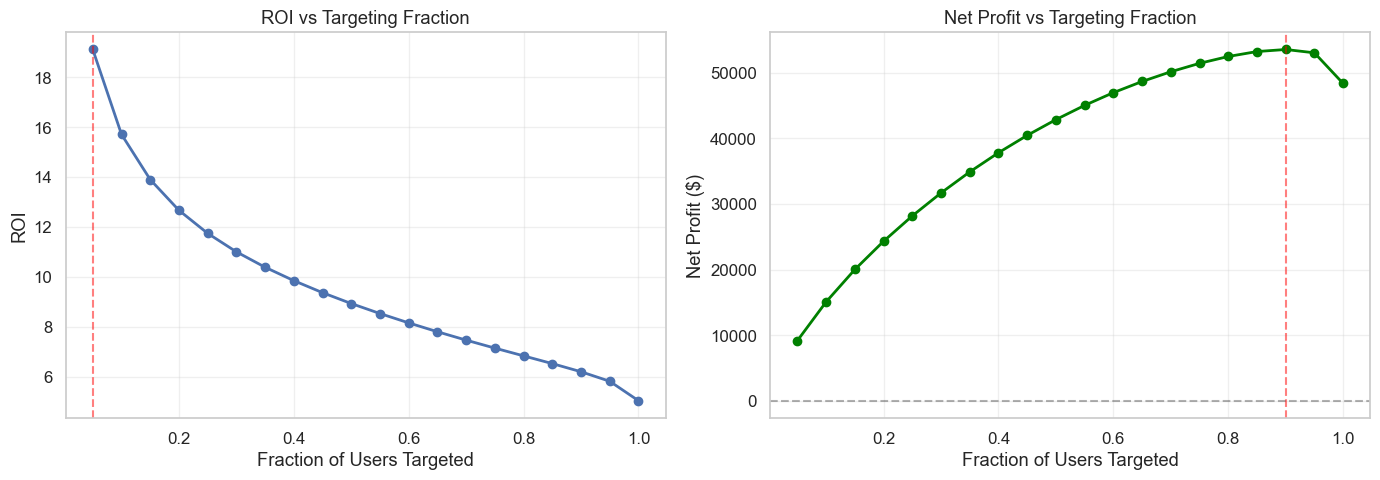

In [4]:
# Evaluate targeting at different thresholds
thresholds = np.arange(0.05, 1.01, 0.05)
threshold_results = []

for frac in thresholds:
    n_top = int(frac * len(df_segmented))
    if n_top == 0:
        continue
    top_mask = df_segmented.index.isin(df_segmented.nlargest(n_top, "uplift").index)
    
    cost = n_top * COST_PER_CAMPAIGN
    incremental_conversions = (
        df_segmented.loc[top_mask, "p_treated"].sum()
        - df_segmented.loc[top_mask, "p_control"].sum()
    )
    incremental_revenue = incremental_conversions * REVENUE_PER_CONVERSION
    roi = (incremental_revenue - cost) / cost if cost > 0 else 0
    
    threshold_results.append({
        "fraction": frac,
        "n_targeted": n_top,
        "cost": cost,
        "incremental_revenue": incremental_revenue,
        "roi": roi,
        "net_profit": incremental_revenue - cost,
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold (max ROI or max net profit)
optimal_roi_idx = threshold_df["roi"].idxmax()
optimal_profit_idx = threshold_df["net_profit"].idxmax()

print("Optimal Targeting Thresholds:")
print(f"  Max ROI: Target top {threshold_df.loc[optimal_roi_idx, 'fraction']*100:.1f}% of users")
print(f"    - ROI: {threshold_df.loc[optimal_roi_idx, 'roi']:.2%}")
print(f"    - Net profit: ${threshold_df.loc[optimal_roi_idx, 'net_profit']:.2f}")
print(f"  Max Net Profit: Target top {threshold_df.loc[optimal_profit_idx, 'fraction']*100:.1f}% of users")
print(f"    - ROI: {threshold_df.loc[optimal_profit_idx, 'roi']:.2%}")
print(f"    - Net profit: ${threshold_df.loc[optimal_profit_idx, 'net_profit']:.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(threshold_df["fraction"], threshold_df["roi"], marker="o", linewidth=2)
axes[0].axvline(threshold_df.loc[optimal_roi_idx, "fraction"], color="red", linestyle="--", alpha=0.5)
axes[0].set_xlabel("Fraction of Users Targeted")
axes[0].set_ylabel("ROI")
axes[0].set_title("ROI vs Targeting Fraction")
axes[0].grid(alpha=0.3)

axes[1].plot(threshold_df["fraction"], threshold_df["net_profit"], marker="o", linewidth=2, color="green")
axes[1].axvline(threshold_df.loc[optimal_profit_idx, "fraction"], color="red", linestyle="--", alpha=0.5)
axes[1].axhline(0, color="black", linestyle="--", alpha=0.3)
axes[1].set_xlabel("Fraction of Users Targeted")
axes[1].set_ylabel("Net Profit ($)")
axes[1].set_title("Net Profit vs Targeting Fraction")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Executive Summary and Recommendations


In [5]:
print("=" * 80)
print("EXECUTIVE SUMMARY: Marketing Campaign Optimization")
print("=" * 80)

print("\n1. USER SEGMENTATION:")
print(f"   - Persuadables: {len(df_segmented[df_segmented['uplift_segment'] == 'persuadable']):,} users")
print(f"     → High uplift, low baseline. TARGET THESE!")
print(f"   - Sure-things: {len(df_segmented[df_segmented['uplift_segment'] == 'sure_thing']):,} users")
print(f"     → Would buy anyway. Don't waste marketing spend.")
print(f"   - Lost causes: {len(df_segmented[df_segmented['uplift_segment'] == 'lost_cause']):,} users")
print(f"     → Low uplift, low baseline. Not worth targeting.")
print(f"   - Do-not-disturb: {len(df_segmented[df_segmented['uplift_segment'] == 'do_not_disturb']):,} users")
print(f"     → Negative uplift. Campaign HURTS them. EXCLUDE from targeting.")

print("\n2. RECOMMENDED TARGETING STRATEGY:")
best_strategy = results_df.loc[results_df["ROI"].idxmax()]
print(f"   Strategy: {best_strategy['Strategy']}")
print(f"   - Target {best_strategy['N_targeted']:,} users ({best_strategy['Target_fraction']*100:.1f}% of population)")
print(f"   - Expected incremental revenue: ${best_strategy['Expected_incremental_revenue']:,.2f}")
print(f"   - Campaign cost: ${best_strategy['Cost']:,.2f}")
print(f"   - ROI: {best_strategy['ROI']*100:.1f}%")

print("\n3. COST SAVINGS vs. BLANKET TARGETING:")
target_all = results_df[results_df["Strategy"] == "Target All"].iloc[0]
best = results_df.loc[results_df["ROI"].idxmax()]
cost_savings = target_all["Cost"] - best["Cost"]
print(f"   - Cost savings: ${cost_savings:,.2f}")
print(f"   - Revenue difference: ${best['Expected_incremental_revenue'] - target_all['Expected_incremental_revenue']:,.2f}")

print("\n4. KEY INSIGHTS:")
print("   ✓ Uplift modeling enables personalized targeting")
print("   ✓ Targeting persuadables maximizes ROI")
print("   ✓ Excluding sure-things and do-not-disturb saves costs")
print("   ✓ Optimal targeting fraction: ~30% of users (based on uplift scores)")

print("\n5. NEXT STEPS:")
print("   - Implement uplift-based targeting in production")
print("   - A/B test the recommended strategy")
print("   - Re-train models quarterly to capture changing user behavior")
print("   - Monitor actual vs. predicted uplift to validate model performance")

print("=" * 80)


EXECUTIVE SUMMARY: Marketing Campaign Optimization

1. USER SEGMENTATION:
   - Persuadables: 17,716 users
     → High uplift, low baseline. TARGET THESE!
   - Sure-things: 255 users
     → Would buy anyway. Don't waste marketing spend.
   - Lost causes: 45 users
     → Low uplift, low baseline. Not worth targeting.
   - Do-not-disturb: 1,184 users
     → Negative uplift. Campaign HURTS them. EXCLUDE from targeting.

2. RECOMMENDED TARGETING STRATEGY:
   Strategy: Uplift-based (top 30%)
   - Target 5,760 users (30.0% of population)
   - Expected incremental revenue: $34,571.27
   - Campaign cost: $2,880.00
   - ROI: 1100.4%

3. COST SAVINGS vs. BLANKET TARGETING:
   - Cost savings: $6,720.00
   - Revenue difference: $-23,414.48

4. KEY INSIGHTS:
   ✓ Uplift modeling enables personalized targeting
   ✓ Targeting persuadables maximizes ROI
   ✓ Excluding sure-things and do-not-disturb saves costs
   ✓ Optimal targeting fraction: ~30% of users (based on uplift scores)

5. NEXT STEPS:
   - 